In [1]:
import os
import cv2
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

from jsonenc import ExtendedEncoder

In [2]:
from nlt import (
    calculate_extrinsic_parameters,
    calculate_world_coordinates,
    MPJPE,
)

In [3]:
# 3つの動画内でそれぞれキューブの位置に写っているかを表すjsonファイル
with open("cube/subsets.json", "r") as f:
    data = json.load(f)

# 画像ポイントを格納するリスト
imgpoints = []

# JSONデータのキーを取得し、ソート
keys = [key for key in data.keys()]
keys.sort()

# ソートされたキーに基づいてデータを処理
for key in keys:
    print(f"key: {key}")  # 現在のキーを出力
    value = data[key]     # キーに対応する値を取得
    imgpoints.append(value)  # 画像ポイントリストに追加

# 画像ポイントをNumPy配列に変換
imgpoints = np.array(imgpoints, dtype=np.float32)

key: cam1_01.MP4
key: cam2_01.MP4
key: cam3_01.MP4


In [4]:
#キューブの各頂点のx,y,z座標を格納したjsonファイル
with open("cube/3d_points.json", "r") as f:
    data = json.load(f)
cube_3d = np.array(data["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [5]:
# 01で作成した"calibration_data.json" ファイルを読み込み、JSONデータを取得
with open("calibration_data.json", 'r') as f:
    data = json.load(f)
# カメラ行列と歪み係数をNumPy配列に変換
mtx = np.array(data["mtx"]).astype(np.float32)
dist = np.array(data["dist"]).astype(np.float32)
print(f"mtx:\n{mtx}")
print(f"dist:\n{dist}")

mtx:
[[7.5549824e+03 0.0000000e+00 2.7280093e+03]
 [0.0000000e+00 7.5905405e+03 1.3734534e+03]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
dist:
[[-2.97993809e-01  9.48251247e+00  2.44860328e-03  1.22051155e-02
  -8.58011169e+01]]


In [6]:
rvecs, tvecs = calculate_extrinsic_parameters(objpoints, imgpoints, mtx, dist)
print(f"rvecs:\n{rvecs}")
print(f"tvecs:\n{tvecs}")

rvecs:
[[-0.35889363  0.4029569  -3.05626177]
 [ 0.34174648  0.42714057 -3.07069327]
 [-0.92138162 -0.43918832  2.9454465 ]]
tvecs:
[[-4.9239634  -0.9651953  21.90833436]
 [-4.65400496 -0.96568396 20.17219322]
 [-3.92427135 -1.10027639 19.44364471]]


In [7]:
n_cameras = len(objpoints)
camera_pairs = list(combinations(range(n_cameras), 2))
print(f"camera_pairs: {camera_pairs}")

camera_pairs: [(0, 1), (0, 2), (1, 2)]


In [8]:
world_coordinates_dict = {}

for camera_pair in camera_pairs:
    world_coordinates = calculate_world_coordinates(
        rvecs[camera_pair[0]], tvecs[camera_pair[0]], mtx, imgpoints[camera_pair[0]],
        rvecs[camera_pair[1]], tvecs[camera_pair[1]], mtx, imgpoints[camera_pair[1]]
    )
    world_coordinates_dict[camera_pair] = world_coordinates
    mpjpe = MPJPE(world_coordinates, cube_3d)
    print(f"MPJPE for camera pair {camera_pair}: {mpjpe:.4f}")

MPJPE for camera pair (0, 1): 0.0927
MPJPE for camera pair (0, 2): 0.0771
MPJPE for camera pair (1, 2): 0.1019


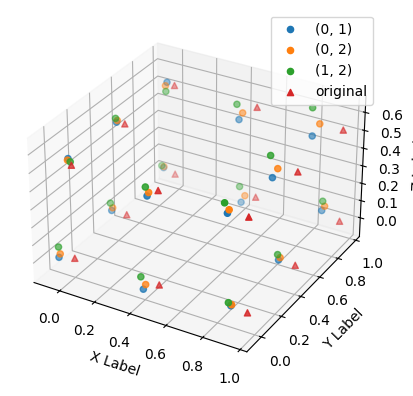

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for camera_pair, world_coordinates in world_coordinates_dict.items():
    ax.scatter(world_coordinates[:, 0], world_coordinates[:, 1], world_coordinates[:, 2], marker='o', label=camera_pair)

ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Labela')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [10]:
mean_world_coordinates = np.mean(list(world_coordinates_dict.values()), axis=0)
mpjpe = MPJPE(mean_world_coordinates, cube_3d)
print(f"MPJPE for mean world coordinates: {mpjpe:.4f}")

MPJPE for mean world coordinates: 0.0858


In [11]:
from files import FileName

cam1_dir = "data/cam1_02_1"
cam2_dir = "data/cam2_02_1"
cam3_dir = "data/cam3_02_1"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")
cam3_position = pd.read_csv(os.path.join(cam3_dir, FileName.position_data), index_col="frame")

In [12]:
name = "RIGHT_WRIST"

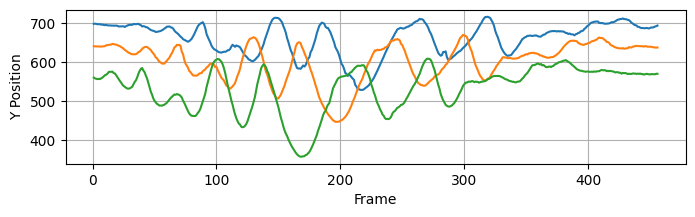

In [13]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"], label=cam1_dir)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"], label=cam2_dir)
ax.plot(cam3_position.index, cam3_position[f"{name}_y"], label=cam3_dir)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
plt.show()

In [14]:
cam1_position.interpolate(method="linear", limit_direction="both", inplace=True)
cam2_position.interpolate(method="linear", limit_direction="both", inplace=True)
cam3_position.interpolate(method="linear", limit_direction="both", inplace=True)

cam1_position_y = cam1_position[f"{name}_y"] - cam1_position[f"{name}_y"].mean()
cam2_position_y = cam2_position[f"{name}_y"] - cam2_position[f"{name}_y"].mean()
cam3_position_y = cam3_position[f"{name}_y"] - cam3_position[f"{name}_y"].mean()

corr = np.correlate(cam1_position_y, cam2_position_y, "full")
delay_frame1 = int(corr.argmax() - (len(cam2_position_y) - 1))
print(f"1-2 delay: {delay_frame1}")

corr = np.correlate(cam1_position_y, cam3_position_y, "full")
delay_frame2 = int(corr.argmax() - (len(cam3_position_y) - 1))
print(f"1-3 delay: {delay_frame2}")

delay_df = pd.DataFrame(columns=["cam1", "cam2", "cam3"])
delay_df.loc[0] = [0, delay_frame1, delay_frame2]

1-2 delay: 19
1-3 delay: 48


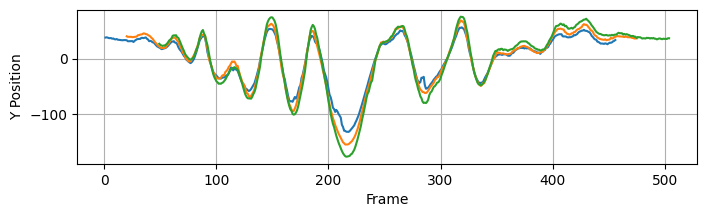

In [15]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position_y, label=cam1_dir)
ax.plot(cam2_position.index + delay_frame1, cam2_position_y, label=cam2_dir)
ax.plot(cam3_position.index + delay_frame2, cam3_position_y, label=cam3_dir)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
plt.show()

In [16]:
cam1_position["ID"] = cam1_position.index
cam2_position["ID"] = cam2_position.index + delay_frame1
cam3_position["ID"] = cam3_position.index + delay_frame2

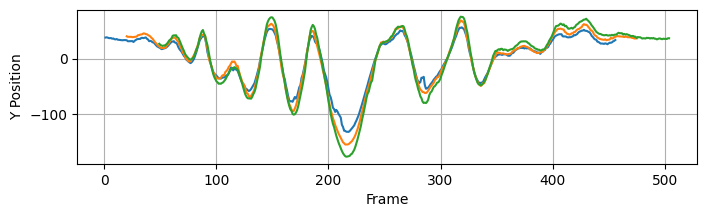

In [17]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.ID, cam1_position_y, label=cam1_dir)
ax.plot(cam2_position.ID, cam2_position_y, label=cam2_dir)
ax.plot(cam3_position.ID, cam3_position_y, label=cam3_dir)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
plt.show()

In [18]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)
cam3_position.set_index("ID", inplace=True, drop=True)

In [19]:
min_frame = int(max(cam1_position.index.min(), cam2_position.index.min(), cam3_position.index.min()))
max_frame = int(min(cam1_position.index.max(), cam2_position.index.max(), cam3_position.index.max()))

print(f"min frame: {min_frame}, max frame: {max_frame}")

min frame: 49, max frame: 456


In [20]:
from skeleton_keypoints import keypoints_list

columns = [f"{kpt}_{xyz}" for kpt in keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_data = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_data = cam2_position.loc[frame].values.reshape(-1, 2)
    cam3_data = cam3_position.loc[frame].values.reshape(-1, 2)
    imgpoints = np.array([cam1_data, cam2_data, cam3_data]).astype(np.float32)

    world_coordinates_dict = {}
    for camera_pair in camera_pairs:
        world_coordinates = calculate_world_coordinates(
            rvecs[camera_pair[0]], tvecs[camera_pair[0]], mtx, imgpoints[camera_pair[0]],
            rvecs[camera_pair[1]], tvecs[camera_pair[1]], mtx, imgpoints[camera_pair[1]]
        )
        world_coordinates_dict[camera_pair] = world_coordinates
    mean_world_coordinates = np.mean(list(world_coordinates_dict.values()), axis=0)
    position_df.loc[frame] = mean_world_coordinates.flatten()

position_df.head()

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_HEEL_z,RIGHT_BIG_TOE_x,RIGHT_BIG_TOE_y,RIGHT_BIG_TOE_z,RIGHT_LITTLE_TOE_x,RIGHT_LITTLE_TOE_y,RIGHT_LITTLE_TOE_z,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_z
frame,,,,,,,,,,,,,,,,,,,,,
49,0.627111,1.612008,0.343824,0.591757,1.640742,0.352636,0.657803,1.638116,0.366226,0.538655,...,0.574864,0.711645,0.014126,0.412861,0.756246,0.019156,0.449895,0.658273,0.035544,0.557706
50,0.626734,1.611481,0.342563,0.590707,1.640730,0.347774,0.658557,1.638115,0.361070,0.537606,...,0.569539,0.713118,0.013348,0.411032,0.756566,0.018472,0.452112,0.655625,0.034859,0.559826
51,0.627351,1.610051,0.340010,0.589543,1.640173,0.345610,0.657336,1.636653,0.358767,0.537143,...,0.563517,0.710265,0.015881,0.405745,0.754815,0.018667,0.453043,0.655819,0.035093,0.560483
52,0.626149,1.606477,0.342094,0.590499,1.638046,0.344173,0.658899,1.634927,0.361001,0.536286,...,0.558882,0.709891,0.015552,0.408162,0.753784,0.018093,0.451786,0.655588,0.033719,0.562744
53,0.625155,1.602956,0.337895,0.589199,1.634927,0.343289,0.657897,1.630366,0.356680,0.536892,...,0.561264,0.708466,0.016078,0.407272,0.753243,0.018628,0.450975,0.653683,0.033637,0.564696


In [21]:
position_df.to_csv("nlt_mean.csv")

In [23]:
from motion_analysis_tool import plot_3d_motion

plot_3d_motion(position_df, output_name="motion.html")